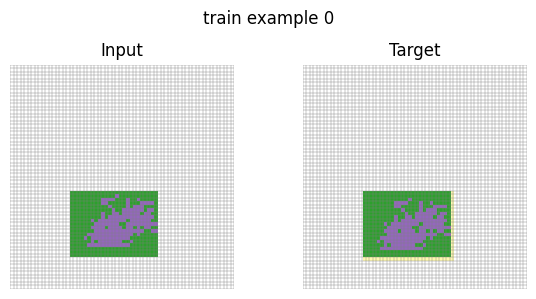

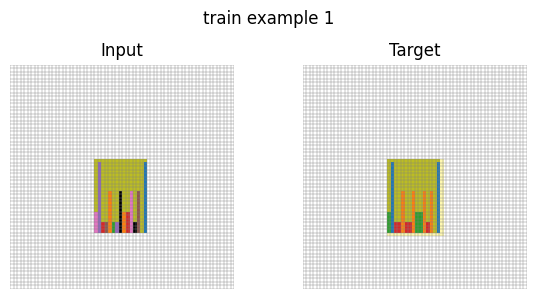

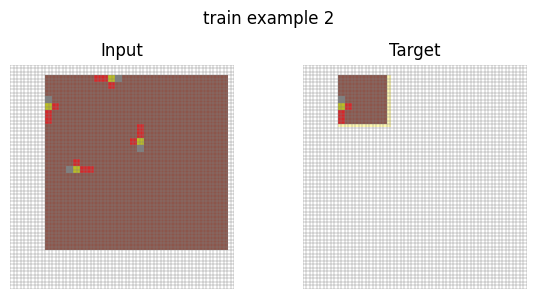

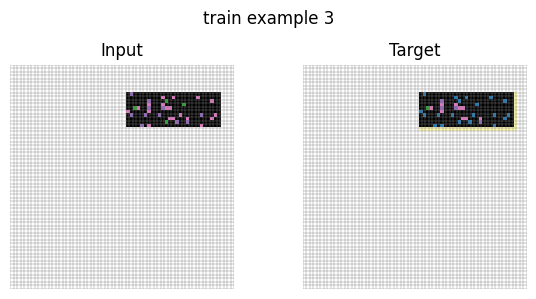

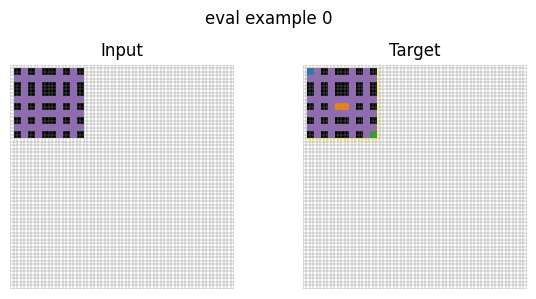

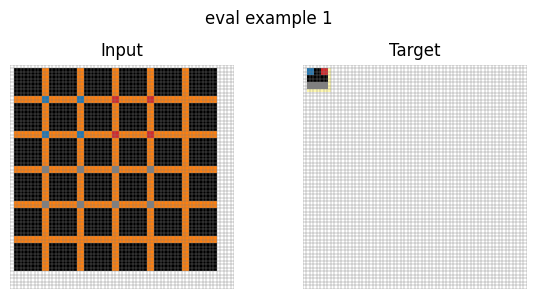

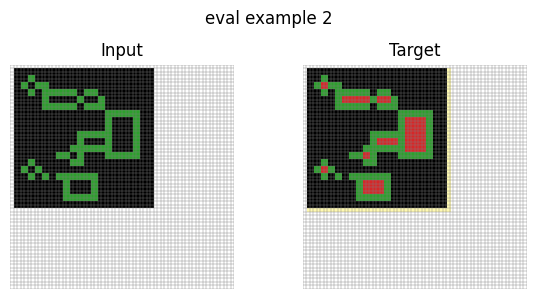

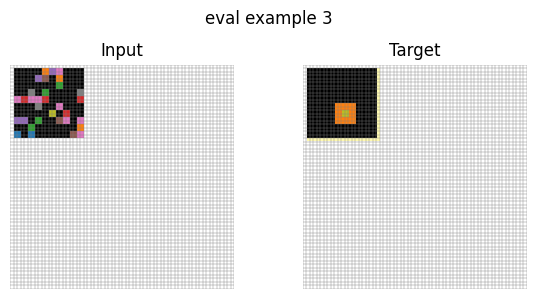

In [1]:
import numpy as np
import jax
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from varc import Dataset, make_augment_batch, IGNORE_INDEX, PAD_INDEX


COLORS = [
    "#000000",
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#ffffff",  # ignore
    "#fff9b0",  # pad
]

ARC_CMAP = ListedColormap(COLORS)
IGNORE_COLOR_IDX = 10
PAD_COLOR_IDX = 11


def create_dataloaders(
    data_path: str = "data/arc",
    rearc_path: str = "data/rearc",
    image_size: int = 64,
    batch_size: int = 8,
):
    train_dataset = Dataset(
        path=Path(data_path),
        split="training",
        subset="train",
        max_size=image_size,
        task_lookup=None,
        extra_train_path=Path(rearc_path),
        seed=0,
        batch_size=batch_size,
        shuffle=True,
    )

    eval_dataset = Dataset(
        path=Path(data_path),
        split="training",
        subset="test",
        max_size=image_size,
        task_lookup=train_dataset.task_lookup,
        extra_train_path=None,
        seed=1,
        batch_size=batch_size,
        shuffle=True,
    )

    train_loader = train_dataset
    eval_loader = eval_dataset

    return train_dataset, train_loader, eval_dataset, eval_loader


def _draw_grid_lines(ax, height: int, width: int):
    for i in range(height + 1):
        ax.axhline(i - 0.5, color="grey", linewidth=0.3)
    for j in range(width + 1):
        ax.axvline(j - 0.5, color="grey", linewidth=0.3)


def to_color_grid(grid) -> np.ndarray:
    arr = np.asarray(grid, dtype=np.int32)
    arr = arr.copy()
    arr[arr == IGNORE_INDEX] = IGNORE_COLOR_IDX
    arr[arr == PAD_INDEX] = PAD_COLOR_IDX
    return arr


def plot_example(inputs, targets, title: str):
    inp_grid = to_color_grid(inputs)
    tgt_grid = to_color_grid(targets)

    fig, axs = plt.subplots(1, 2, figsize=(6, 3))

    axs[0].imshow(inp_grid, cmap=ARC_CMAP, vmin=0, vmax=len(COLORS) - 1)
    _draw_grid_lines(axs[0], inp_grid.shape[0], inp_grid.shape[1])
    axs[0].set_title("Input")
    axs[0].axis("off")

    axs[1].imshow(tgt_grid, cmap=ARC_CMAP, vmin=0, vmax=len(COLORS) - 1)
    _draw_grid_lines(axs[1], tgt_grid.shape[0], tgt_grid.shape[1])
    axs[1].set_title("Target")
    axs[1].axis("off")

    fig.suptitle(title)
    fig.tight_layout()
    return fig


def plot_batch(batch: dict, split: str, num_examples: int = 4):
    inputs = batch["inputs"]
    targets = batch["targets"]
    bsz = inputs.shape[0]
    num = min(bsz, num_examples)

    for i in range(num):
        fig = plot_example(
            inputs[i],
            targets[i],
            title=f"{split} example {i}",
        )
        plt.show()


train_dataset, train_loader, eval_dataset, eval_loader = create_dataloaders()

train_augment = make_augment_batch(
    max_size=train_dataset.max_size,
    resolution_enabled=True,
    translation_enabled=True,
    fix_scale_factor=2,
)

eval_augment = make_augment_batch(
    max_size=eval_dataset.max_size,
    resolution_enabled=False,
    translation_enabled=False,
    fix_scale_factor=2,
)

key = jax.random.PRNGKey(0)

train_raw = next(iter(train_loader))
key, subkey = jax.random.split(key)
train_batch = train_augment(subkey, train_raw)

eval_raw = next(iter(eval_loader))
key, subkey = jax.random.split(key)
eval_batch = eval_augment(subkey, eval_raw)

plot_batch(train_batch, split="train", num_examples=4)
plot_batch(eval_batch, split="eval", num_examples=4)


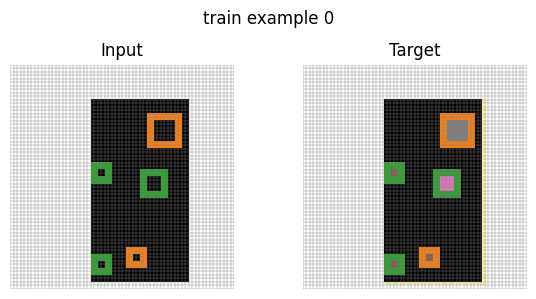

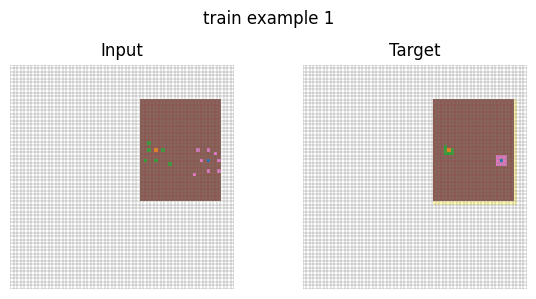

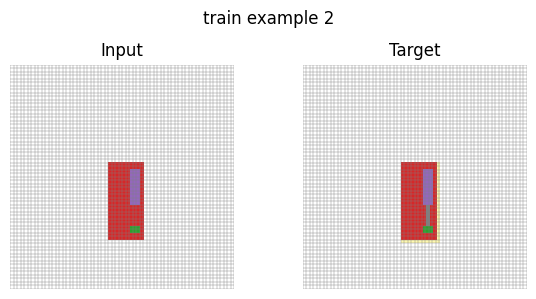

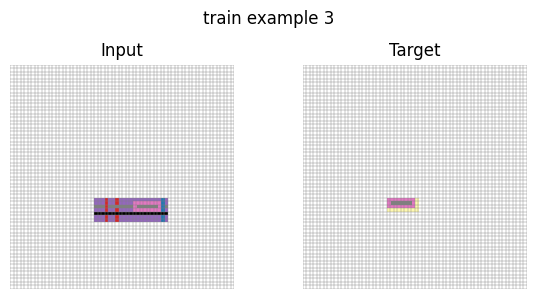

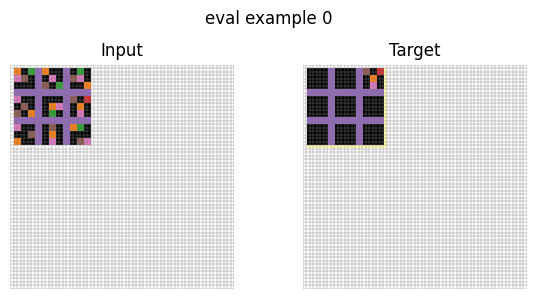

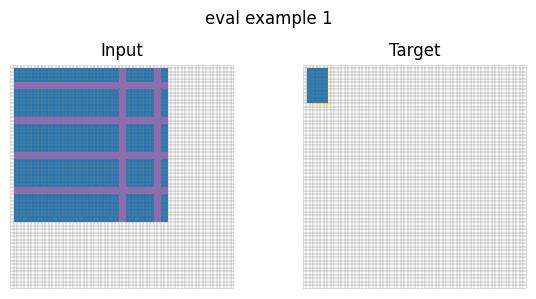

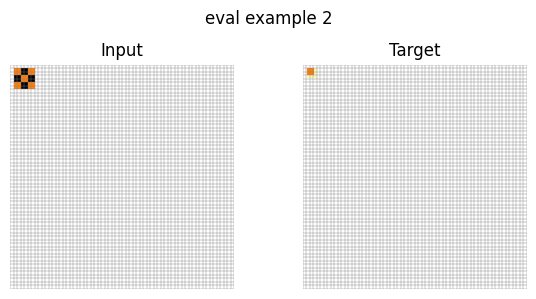

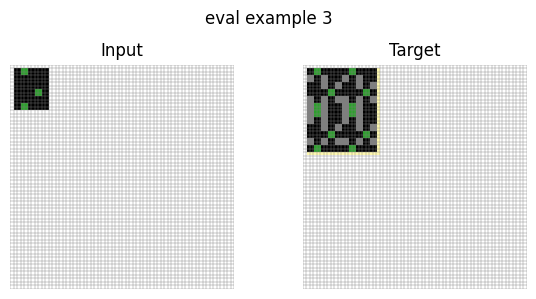

In [3]:
train_raw = next(iter(train_loader))
key, subkey = jax.random.split(key)
train_batch = train_augment(subkey, train_raw)

eval_raw = next(iter(eval_loader))
key, subkey = jax.random.split(key)
eval_batch = eval_augment(subkey, eval_raw)

plot_batch(train_batch, split="train", num_examples=4)
plot_batch(eval_batch, split="eval", num_examples=4)
